# imports

In [1]:
import os
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython import display

In [35]:
import tensorflow as tf

x = tf.keras.layers.ConvLSTM2D(filters=4, kernel_size=(3, 3), padding="same", return_sequences=False, data_format="channels_last")

# dummy input of shape (1, 8, 256, 256)
input = tf.random.normal((1, 8, 256, 256, 1))
output = x(input)

# Maxpooling
print(output.shape)
# multiple output by -1 to invert the colors
output = output * -1
max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same", data_format="channels_last")
output = max_pool(output)
print(output.shape)

(1, 256, 256, 4)
(1, 128, 128, 4)


In [37]:
lis = [1,2,3]
# change it to tuple
tup = tuple(lis)

In [38]:
len(tup)

3

# Paths

In [2]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    BASE_DIR = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
else:
    BASE_DIR =  'data/train'

N_TIMES_BEFORE = 4
# randomly select a record_id from BASE_DIR
record_id = np.random.choice(os.listdir(BASE_DIR))
# record_id = '1000216489776414077'   # without contrails
# record_id = '1704010292581573769'   # with contrails

- Load the dataset to numpy arrays

In [3]:
with open(os.path.join(BASE_DIR, record_id, 'band_11.npy'), 'rb') as f:  # cloud top phase band (IR)
    band11 = np.load(f)            # (256, 256, 8)  
with open(os.path.join(BASE_DIR, record_id, 'band_14.npy'), 'rb') as f:  # IR longwave Window band (IR)
    band14 = np.load(f)             # (256, 256, 8)
with open(os.path.join(BASE_DIR, record_id, 'band_15.npy'), 'rb') as f:  # "Dirty" Longwave Window Band (IR)
    band15 = np.load(f)            # (256, 256, 8)
with open(os.path.join(BASE_DIR, record_id, 'human_pixel_masks.npy'), 'rb') as f:
    human_pixel_mask = np.load(f)  # (256, 256, 1) # 1: for particular time when anotation was made
with open(os.path.join(BASE_DIR, record_id, 'human_individual_masks.npy'), 'rb') as f:
    human_individual_mask = np.load(f) # (256, 256, 1, 4)  # 4: number of human, 1: for particular time when anotation was made

## Combine bands into a false color image

In order to view contrails in GOES, we use the "ash" color scheme. This color scheme was originally developed for viewing volcanic ash in the atmosphere but is also useful for viewing thin cirrus, including contrails. In this color scheme, contrails appear in the image as dark blue.

Note that we use a modified version of the ash color scheme here, developed by Kulik et al., which uses slightly different bands and bounds tuned for contrails.

In [4]:
# stack all bands
bands = np.stack([band11, band14, band15], axis=-1)  # (256, 256, 8, 3)

bands.shape

(256, 256, 8, 3)

In [5]:
_T11_BOUNDS = (243, 303) 
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5) 
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
b = normalize_range(band14, _T11_BOUNDS)
false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)  # shape is (256, 256, 3, 8), here t= n_before + n_after + 1 i.e. (4 + 3 + 1)

## Visualize the image

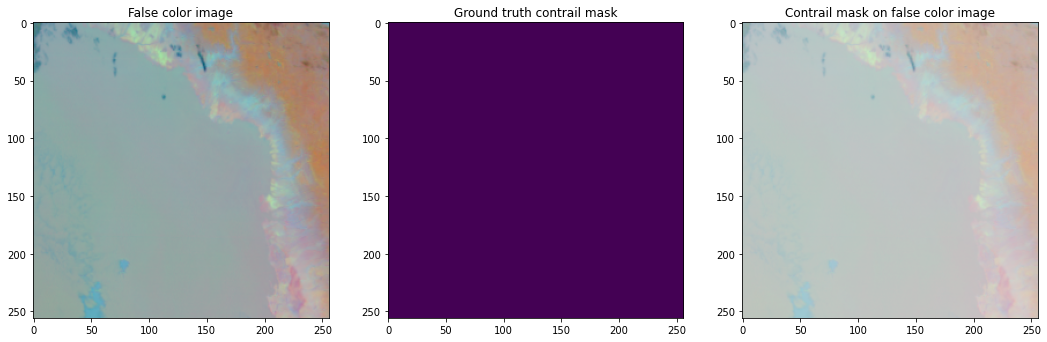

In [8]:
img = false_color[..., N_TIMES_BEFORE]

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(human_pixel_mask, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
ax.set_title('Contrail mask on false color image');

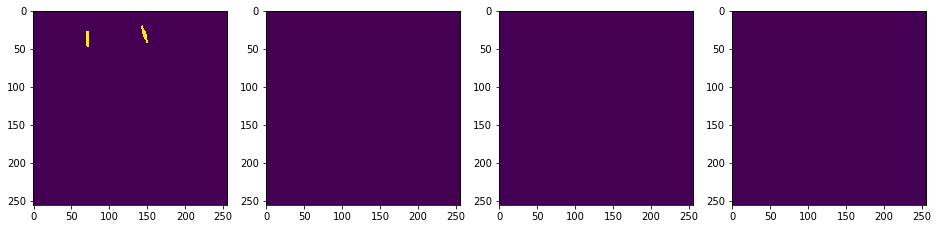

In [7]:
# Individual human masks
n = human_individual_mask.shape[-1]
plt.figure(figsize=(16, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(human_individual_mask[..., i], interpolation='none')

In [17]:
# Animation
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(false_color[..., 0])
def draw(i):
    im.set_array(false_color[..., i])
    return [im]
anim = animation.FuncAnimation(
    fig, draw, frames=false_color.shape[-1], interval=500, blit=True
)
plt.close()
display.HTML(anim.to_jshtml())